In [1]:
import requests
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# our own package for reading the data
import sddk

In [13]:
# read and execute our script for modelling dates
script_url = "https://raw.githubusercontent.com/sdam-au/modelling_temporal_uncertainty/master/scripts/modelling_distributions.py"
# execute the script
exec(requests.get(script_url).content)

In [2]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648560@au.dk
sciencedata.dk password: ··········
connection with shared folder established with you as its ordinary user
endpoint variable has been configured to: https://sciencedata.dk/sharingout/648597%40au.dk/SDAM_root/


In [7]:
# read the EDH dataset from sciencedata.dk
EDH = sddk.read_file("SDAM_data/EDH/EDH_cleaned_2020-06-26.json", "df", conf)

In [8]:
EDH.head(5)

,diplomatic_text,literature,trismegistos_uri,id,findspot_ancient,not_before,type_of_inscription,work_status,edh_geography_uri,not_after,country,province_label,transcription,material,height,width,findspot_modern,depth,commentary,uri,responsible_individual,last_update,language,modern_region,letter_size,type_of_monument,people,year_of_find,findspot,present_location,external_image_uris,religion,fotos,geography,military,social_economic_legal_history,coordinates,text_cleaned,origdate_text,origdate_attrs,objecttype,province_label_clean,province_label_certainty,type_of_inscription_clean,material_clean,height_cm,width_cm,depth_cm,type_of_monument_clean,type_of_monument_certainty,findspot_ancient_clean,findspot_ancient_certainty,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence
0,[D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMON...,"[AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 1...",[https://www.trismegistos.org/text/251193],[HD000001],"[Cumae, bei]",[0071],[epitaph],[provisional],[https://edh-www.adw.uni-heidelberg.de/edh/geo...,[0130],[Italy],[Latium et Campania (Regio I)],[D(is) M(anibus) / Noniae P(ubli) f(iliae) Opt...,"[Marmor, geädert / farbig]",[33 cm],[34 cm],"[Cuma, bei]",[2.7 cm],[ (C): 2. Hälfte 1. - Anfang 2. Jh. - AE; Ende...,[https://edh-www.adw.uni-heidelberg.de/edh/ins...,[Feraudi],[2014-04-07],[Latin],[Campania],[3.2-2 cm],[tabula],"[{'cognomen': 'Optata', 'person_id': '1', 'gen...",{},{},{},{},{},{},{},{},{},"[40.8471577,14.0550756]",[Dis Manibus Noniae Publi filiae Optatae et Ca...,[71 AD – 130 AD ],"{'notbefore-custom': ['0071'], 'notafter-custo...","[Tafel, 257]",Latium et Campania (Regio I),Certain,epitaph,Marble,33.0,34.0,2.7,tabula,Certain,Cumae,Estimated,D M Noniae P f Optatae et C Iulio Artemoni par...,Dis Manibus Noniae Publi filiae Optatae et Cai...,Dis Manibus Noniae Publi filiae Optatae et Cai...
1,[C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX],"[AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, ...",[https://www.trismegistos.org/text/265631],[HD000002],[Roma],[0051],[epitaph],[no image],[https://edh-www.adw.uni-heidelberg.de/edh/geo...,[0200],[Italy],[Roma],[C(aius) Sextius Paris / qui vixit / annis LXX],[marble: rocks - metamorphic rocks],[28 cm],[85 cm],[Roma],{},[ AE 1983: Breite: 35 cm.],[https://edh-www.adw.uni-heidelberg.de/edh/ins...,[Feraudi],[2014-04-07],[Latin],[Lazio],[4 cm],[tabula],"[{'age: years': '70', 'cognomen': 'Paris', 'ge...",[1937],"[Via Nomentana, S. Alessandro, Kirche]",{},{},{},{},{},{},{},"[41.895466,12.482324]",[Caius Sextius Paris qui vixit annis LXX ...,[51 AD – 200 AD ],"{'notbefore-custom': ['0051'], 'notafter-custo...","[Tafel, 257]",Roma,Certain,epitaph,Marble,28.0,85.0,NaN,tabula,Certain,Roma,Certain,C Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX
2,[[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ]...,"[AE 1983, 0518. (B); J. González, ZPE 52, 1983...",[https://www.trismegistos.org/text/220675],[HD000003],{},[0131],[honorific inscription],[provisional],[https://edh-www.adw.uni-heidelberg.de/edh/geo...,[0170],[Spain],[Baetica],[[P(ublio) M]ummio [P(ubli) f(ilio)] / [Gal(er...,[marble: rocks - metamorphic rocks],[(37) cm],[(34) cm],[Tomares],[(12) cm],[ (B): [S]isenna ist falscher Kasus; folgende ...,[https://edh-www.adw.uni-heidelberg.de/edh/ins...,[Feraudi],[2006-08-31],[Latin],[Sevilla],[4.5-3 cm],[statue base],"[{'nomen': 'Mummius+', 'cognomen': 'Sisenna+ R...",[before 1975],{},"[Sevilla, Privatbesitz]",{},{},{},{},{},{},"[37.37281,-6.04589]",[Publio Mummio Publi filio Galeria Sisennae Ru...,[131 AD – 170 AD ],"{'notbefore-custom': ['0131'], 'notafter-custo...","[Statuenbasis, 57]",Baetica,Certain,honorific inscription,Marble,37.0,34.0,12.0,statue base,Certain,NULL,NULL,ummio isenna Xv,Publio Mummio Publi filio Galeria Sisennae Rut...,Publio Mummio Publi filio Galeria Sisennae Rut...
3,[[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VE...,"[AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 19...

In [10]:
### how many of the inscriptions have at least one date
len(EDH[(EDH["not_before"].notnull()) | (EDH["not_after"].notnull())])

80270

# Generate random dates for the whole dataset

In [17]:
def lists_to_values(list_or_value):
  if isinstance(list_or_value, list):
    value = list_or_value[0]
  else: 
    value = list_or_value
  return value
for column in EDH.columns:
  EDH[column] = EDH.apply(lambda row: lists_to_values(row[column]), axis=1)

In [18]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
EDH["random_dates"] =EDH.apply(lambda row: model_date(row["not_before"], row["not_after"], size=1000,), axis=1)

CPU times: user 40.1 s, sys: 950 ms, total: 41.1 s
Wall time: 41.1 s


In [19]:
EDH.head(5)

,diplomatic_text,literature,trismegistos_uri,id,findspot_ancient,not_before,type_of_inscription,work_status,edh_geography_uri,not_after,country,province_label,transcription,material,height,width,findspot_modern,depth,commentary,uri,responsible_individual,last_update,language,modern_region,letter_size,type_of_monument,people,year_of_find,findspot,present_location,external_image_uris,religion,fotos,geography,military,social_economic_legal_history,coordinates,text_cleaned,origdate_text,origdate_attrs,objecttype,province_label_clean,province_label_certainty,type_of_inscription_clean,material_clean,height_cm,width_cm,depth_cm,type_of_monument_clean,type_of_monument_certainty,findspot_ancient_clean,findspot_ancient_certainty,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,random_dates
0,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",https://www.trismegistos.org/text/251193,HD000001,"Cumae, bei",0071,epitaph,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0130,Italy,Latium et Campania (Regio I),D(is) M(anibus) / Noniae P(ubli) f(iliae) Opta...,"Marmor, geädert / farbig",33 cm,34 cm,"Cuma, bei",2.7 cm,(C): 2. Hälfte 1. - Anfang 2. Jh. - AE; Ende ...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Campania,3.2-2 cm,tabula,"{'cognomen': 'Optata', 'person_id': '1', 'gend...",{},{},{},{},{},{},{},{},{},"40.8471577,14.0550756",Dis Manibus Noniae Publi filiae Optatae et Cai...,71 AD – 130 AD,"{'notbefore-custom': ['0071'], 'notafter-custo...",Tafel,Latium et Campania (Regio I),Certain,epitaph,Marble,33.0,34.0,2.7,tabula,Certain,Cumae,Estimated,D M Noniae P f Optatae et C Iulio Artemoni par...,Dis Manibus Noniae Publi filiae Optatae et Cai...,Dis Manibus Noniae Publi filiae Optatae et Cai...,"[119, 101, 83, 119, 74, 94, 112, 96, 96, 110, ..."
1,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",https://www.trismegistos.org/text/265631,HD000002,Roma,0051,epitaph,no image,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Italy,Roma,C(aius) Sextius Paris / qui vixit / annis LXX,marble: rocks - metamorphic rocks,28 cm,85 cm,Roma,{},AE 1983: Breite: 35 cm.,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Lazio,4 cm,tabula,"{'age: years': '70', 'cognomen': 'Paris', 'gen...",1937,"Via Nomentana, S. Alessandro, Kirche",{},{},{},{},{},{},{},"41.895466,12.482324",Caius Sextius Paris qui vixit annis LXX ...,51 AD – 200 AD,"{'notbefore-custom': ['0051'], 'notafter-custo...",Tafel,Roma,Certain,epitaph,Marble,28.0,85.0,NaN,tabula,Certain,Roma,Certain,C Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,"[167, 52, 102, 174, 122, 135, 64, 151, 161, 19..."
2,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",https://www.trismegistos.org/text/220675,HD000003,{},0131,honorific inscription,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0170,Spain,Baetica,[P(ublio) M]ummio [P(ubli) f(ilio)] / [Gal(eri...,marble: rocks - metamorphic rocks,(37) cm,(34) cm,Tomares,(12) cm,(B): [S]isenna ist falscher Kasus; folgende E...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2006-08-31,Latin,Sevilla,4.5-3 cm,statue base,"{'nomen': 'Mummius+', 'cognomen': 'Sisenna+ Ru...",before 1975,{},"Sevilla, Privatbesitz",{},{},{},{},{},{},"37.37281,-6.04589",Publio Mummio Publi filio Galeria Sisennae Rut...,131 AD – 170 AD,"{'notbefore-custom': ['0131'], 'notafter-custo...",Statuenbasis,Baetica,Certain,honorific inscription,Marble,37.0,34.0,12.0,statue base,Certain,NULL,NULL,ummio isenna Xv,Publio Mummio Publi filio Galeria Sisennae Rut...,Publio Mummio Publi filio Galeria Sisennae Rut...,"[153, 153, 158, 137, 147, 147, 135, 133, 168, ..."
3,[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VEN...,"AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 198...",http

# EDH dataset overview

In [20]:
len(EDH)

80270

In [21]:
len(EDH[EDH["random_dates"].notna()])

57782

In [23]:
# how many % are dated / generated random numbers
len(EDH[EDH["random_dates"].notna()]) / len(EDH)*100

71.98455213653918

In [ ]:
# filter for dated
EDH_dated = EDH[EDH["not_before"].notnull()]

In [32]:
len(EDH_dated[(EDH_dated["not_before"] >= -100) & (EDH_dated["not_before"] <= 100)])

TypeError: ignored

In [29]:
# post quem
post = EDH[EDH["not_before"].notna() & (EDH["not_after"].isna())]
len(post)

0

In [30]:
#ante quem
ante = EDH[EDH["not_after"].notna() & (EDH["not_before"].isna())]
len(ante)

0

In [33]:
ranges = EDH[EDH["not_after"].notna() & (EDH["not_before"].notna())]
len(ranges)

80270

In [35]:
def get_duration(start, stop):
  try:
    duration = abs(int(start) - int(stop)) + 1
    if 0 in range(int(start),  int(stop)):
      duration = duration - 1
  except:
    duration = np.nan
  return duration
  

EDH["duration"] = EDH.apply(lambda row: get_duration(row["not_before"], row["not_after"]), axis=1)

In [37]:
EDH.head(2)

,diplomatic_text,literature,trismegistos_uri,id,findspot_ancient,not_before,type_of_inscription,work_status,edh_geography_uri,not_after,country,province_label,transcription,material,height,width,findspot_modern,depth,commentary,uri,responsible_individual,last_update,language,modern_region,letter_size,type_of_monument,people,year_of_find,findspot,present_location,external_image_uris,religion,fotos,geography,military,social_economic_legal_history,coordinates,text_cleaned,origdate_text,origdate_attrs,objecttype,province_label_clean,province_label_certainty,type_of_inscription_clean,material_clean,height_cm,width_cm,depth_cm,type_of_monument_clean,type_of_monument_certainty,findspot_ancient_clean,findspot_ancient_certainty,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,random_dates,duration
0,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",https://www.trismegistos.org/text/251193,HD000001,"Cumae, bei",0071,epitaph,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0130,Italy,Latium et Campania (Regio I),D(is) M(anibus) / Noniae P(ubli) f(iliae) Opta...,"Marmor, geädert / farbig",33 cm,34 cm,"Cuma, bei",2.7 cm,(C): 2. Hälfte 1. - Anfang 2. Jh. - AE; Ende ...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Campania,3.2-2 cm,tabula,"{'cognomen': 'Optata', 'person_id': '1', 'gend...",{},{},{},{},{},{},{},{},{},"40.8471577,14.0550756",Dis Manibus Noniae Publi filiae Optatae et Cai...,71 AD – 130 AD,"{'notbefore-custom': ['0071'], 'notafter-custo...",Tafel,Latium et Campania (Regio I),Certain,epitaph,Marble,33.0,34.0,2.7,tabula,Certain,Cumae,Estimated,D M Noniae P f Optatae et C Iulio Artemoni par...,Dis Manibus Noniae Publi filiae Optatae et Cai...,Dis Manibus Noniae Publi filiae Optatae et Cai...,"[119, 101, 83, 119, 74, 94, 112, 96, 96, 110, ...",60.0
1,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",https://www.trismegistos.org/text/265631,HD000002,Roma,0051,epitaph,no image,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Italy,Roma,C(aius) Sextius Paris / qui vixit / annis LXX,marble: rocks - metamorphic rocks,28 cm,85 cm,Roma,{},AE 1983: Breite: 35 cm.,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Lazio,4 cm,tabula,"{'age: years': '70', 'cognomen': 'Paris', 'gen...",1937,"Via Nomentana, S. Alessandro, Kirche",{},{},{},{},{},{},{},"41.895466,12.482324",Caius Sextius Paris qui vixit annis LXX ...,51 AD – 200 AD,"{'notbefore-custom': ['0051'], 'notafter-custo...",Tafel,Roma,Certain,epitaph,Marble,28.0,85.0,NaN,tabula,Certain,Roma,Certain,C Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,Caius Sextius Paris qui vixit annis LXX,"[167, 52, 102, 174, 122, 135, 64, 151, 161, 19...",150.0


Text(0.5, 1.0, '')

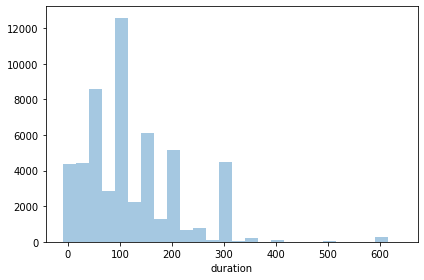

In [44]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
sns.distplot(EDH["duration"], kde=False, bins=range(-10, 650,25), ax=ax)
ax.set_title("")

In [45]:
sddk.write_file("SDAM_data/temporal_uncertainty/EDH_ranges_hist.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/sharingout/648597%40au.dk/SDAM_root/SDAM_data/temporal_uncertainty/EDH_ranges_hist.png"


# Simulations with complete dataset

In [51]:
%%time
EDH_complete_simulations = timeblocks_from_randoms(EDH, "random_dates", [-1000, 1000, 50])

CPU times: user 39.6 s, sys: 428 ms, total: 40 s
Wall time: 40.1 s


In [52]:
EDH_complete_simulations[1]

[((-1000, -951), 0),
 ((-950, -901), 0),
 ((-900, -851), 0),
 ((-850, -801), 0),
 ((-800, -751), 0),
 ((-750, -701), 0),
 ((-700, -651), 0),
 ((-650, -601), 0),
 ((-600, -551), 0),
 ((-550, -501), 1),
 ((-500, -451), 0),
 ((-450, -401), 0),
 ((-400, -351), 2),
 ((-350, -301), 3),
 ((-300, -251), 9),
 ((-250, -201), 16),
 ((-200, -151), 38),
 ((-150, -101), 74),
 ((-100, -51), 230),
 ((-50, -1), 1029),
 ((1, 50), 4776),
 ((51, 100), 6406),
 ((101, 150), 10090),
 ((151, 200), 12526),
 ((201, 250), 11192),
 ((251, 300), 5997),
 ((301, 350), 1593),
 ((351, 400), 1374),
 ((401, 450), 738),
 ((451, 500), 598),
 ((501, 550), 416),
 ((551, 600), 383),
 ((601, 650), 139),
 ((651, 700), 98),
 ((701, 750), 21),
 ((751, 800), 7),
 ((801, 850), 2),
 ((851, 900), 1),
 ((901, 950), 1),
 ((951, 1000), 1)]

In [53]:
def desc_stat_from_simulations(simulations):
  tups_desc = []
  for n in range(len(simulations[0])):
    values = [sim[n][1] for sim in simulations]
    tups_desc.append((simulations[0][n][0], np.min(values), np.max(values), np.mean(values), np.median(values)))
  tups_desc_df = pd.DataFrame(tups_desc)
  tups_desc_df.columns = ["temp_block", "min", "max", "mean", "median"]
  return tups_desc_df

In [54]:
sims_by_blocks = desc_stat_from_simulations(EDH_complete_simulations)
sims_by_blocks.set_index("temp_block", inplace=True)
sims_by_blocks

,min,max,mean,median
temp_block,,,,
"(-1000, -951)",0,0,0.000,0.0
"(-950, -901)",0,0,0.000,0.0
"(-900, -851)",0,0,0.000,0.0
"(-850, -801)",0,0,0.000,0.0
"(-800, -751)",0,0,0.000,0.0
"(-750, -701)",0,0,0.000,0.0
"(-700, -651)",0,0,0.000,0.0
"(-650, -601)",0,0,0.000,0.0
"(-600, -551)",0,0,0.000,0.0


In [55]:
from pandas.plotting import table

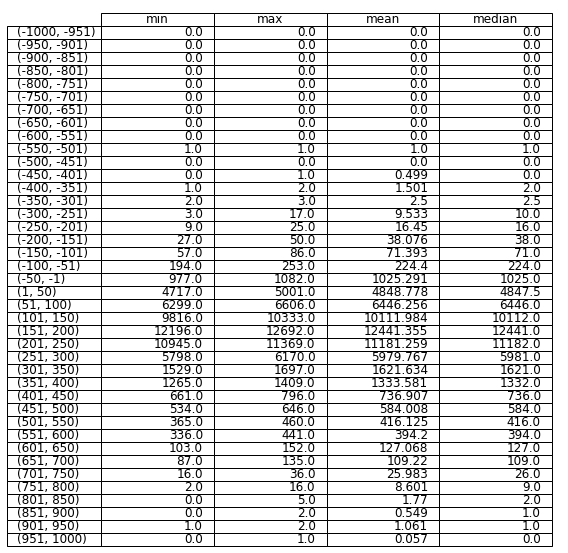

In [56]:
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)
tabla = table(ax, sims_by_blocks, loc='upper right', colWidths=[0.2]*len(sims_by_blocks.columns))
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) 

In [57]:
sddk.write_file("SDAM_data/temporal_uncertainty/EDH_sims_by_blocks.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/sharingout/648597%40au.dk/SDAM_root/SDAM_data/temporal_uncertainty/EDH_sims_by_blocks.png"


In [58]:
sddk.write_file("SDAM_data/temporal_uncertainty/EDH_sims_by_blocks.csv", sims_by_blocks, conf)

Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/sharingout/648597%40au.dk/SDAM_root/SDAM_data/temporal_uncertainty/EDH_sims_by_blocks.csv"


In [59]:
# compare in how many instances is there less inscriptions for the first half of the 2nd c. than for the second half.
len([sim for sim in EDH_complete_simulations if sim[18][1] < sim[19][1]])

1000

In [60]:
len([date for date in EDH_date_avr if not np.isnan(date)])

NameError: ignored